In [27]:
import os
from pathlib import Path
import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
from sklearn.model_selection import train_test_split
np.random.seed(111)

Using TensorFlow backend.


In [4]:
import requests
test_url = 'https://k.kakaocdn.net/dn/bFvix1/btqDiGxBP3H/8YrhvZb6oyomwdQvFZRRR0/test.zip?attach=1&knm=tfile.zip'
train_cleaned_url = 'https://k.kakaocdn.net/dn/bLEltV/btqDkAwtxMN/g8lrXy5ACYiXzG9hAkLi50/train_cleaned.zip?attach=1&knm=tfile.zip'
train1_url = 'https://k.kakaocdn.net/dn/biFTCp/btqDje8LwJq/Nsk90EPjV77rDSbJZz3EW0/train1.zip?attach=1&knm=tfile.zip'
train2_url = 'https://k.kakaocdn.net/dn/rOqax/btqDiGxBWOn/xb3It6FhqbqeDxxTvEXAi1/train2.zip?attach=1&knm=tfile.zip'

file1 = requests.get(test_url, allow_redirects=True)
open('test.zip', 'wb').write(file1.content)
print("test.zip 파일이 다운로드 되었습니다.")

file2 = requests.get(train_cleaned_url, allow_redirects=True)
open('train_cleaned.zip', 'wb').write(file2.content)
print("train_cleaned.zip 파일이 다운로드 되었습니다.")

file3 = requests.get(train1_url, allow_redirects=True)
open('train1.zip', 'wb').write(file3.content)
print("train1.zip 파일이 다운로드 되었습니다.")

file4 = requests.get(train2_url, allow_redirects=True)
open('train2.zip', 'wb').write(file4.content)
print("train2.zip 파일이 다운로드 되었습니다.")

test.zip 파일이 다운로드 되었습니다.
train_cleaned.zip 파일이 다운로드 되었습니다.
train1.zip 파일이 다운로드 되었습니다.
train2.zip 파일이 다운로드 되었습니다.


In [5]:
import zipfile as z ######압축파일 해제
data = z.ZipFile('./test.zip')
data.extractall('./test') ######이 이름의 폴더가 없어도 알아서 test 라는 폴더 만들어 줌
data = z.ZipFile('./train1.zip')
data.extractall('./train')
data = z.ZipFile('./train2.zip')
data.extractall('./train')
data = z.ZipFile('./train_cleaned.zip')
data.extractall('./train_cleaned')
data.close()

In [6]:
######불필요한 파일 지우기 ######
os.remove('./test.zip')
os.remove('./train1.zip')
os.remove('./train2.zip')
os.remove('./train_cleaned.zip')

In [24]:
from pathlib import Path
test = Path('./test/test')
train = Path('./train')
train_cleaned = Path('./train_cleaned/train_cleaned')

train_images = sorted(os.listdir(train))
train_labels = sorted(os.listdir(train_cleaned))
test_images = sorted(os.listdir(test))
print("Total number of images in the training set: ", len(train_images))
print("Total number of cleaned images found: ", len(train_labels))
print("Total number of samples in the test set: ", len(test_images))

Total number of images in the training set:  144
Total number of cleaned images found:  144
Total number of samples in the test set:  72


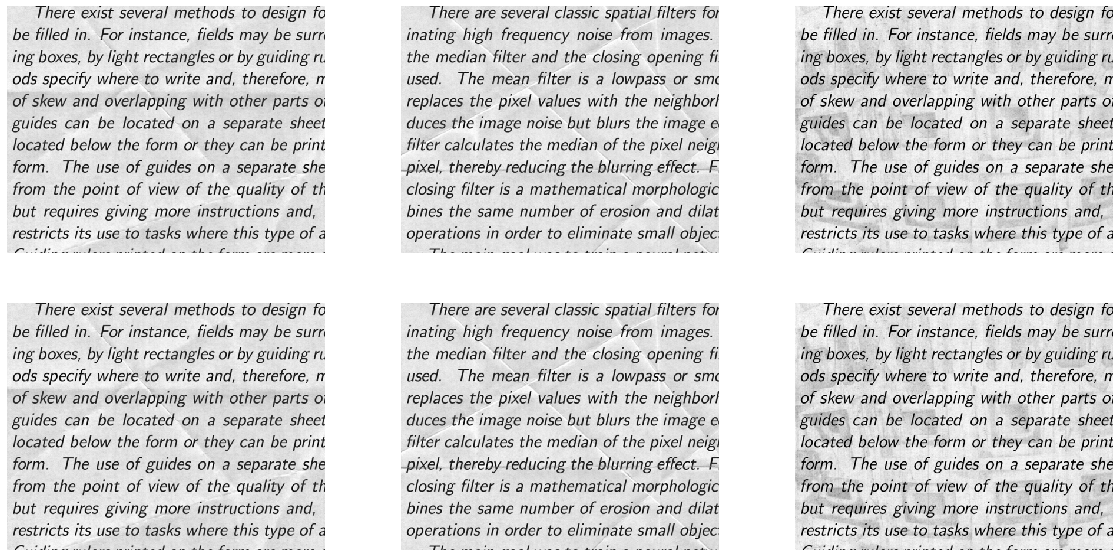

In [34]:
# Lets' plot a few samples
# First row will be raw data, second row will be the corresponding cleaned images
samples = train_images[:3] + train_labels[:3]

f, ax = plt.subplots(2, 3, figsize=(20,10))
for i, img in enumerate(samples):
    img = imread(train/img)
    ax[i//3, i%3].imshow(img, cmap='gray')
    ax[i//3, i%3].axis('off')
plt.show()    

In [35]:
def build_autoenocder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    #enoder 
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
    
    #decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

In [36]:
autoencoder = build_autoenocder()
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 420, 540, 1)       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 420, 540, 32)      320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 210, 270, 32)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 210, 270, 64)      18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 105, 135, 64)      0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 105, 135, 64)      36928     
_________________________________________________________________
upsample1 (UpSampling2D)     (None, 210, 270, 64)      0   

In [38]:
X = []
Y = []

for img in train_images:
    img = load_img(train / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X.append(img)

for img in train_labels:
    img = load_img(train_cleaned / img, color_mode = "grayscale",target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)


X = np.array(X)
Y = np.array(Y)

print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)

Size of X :  (144, 420, 540, 1)
Size of Y :  (144, 420, 540, 1)


In [39]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=111)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)

Total number of training samples:  (129, 420, 540, 1)
Total number of validation samples:  (15, 420, 540, 1)


In [40]:
autoencoder.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_valid, y_valid))

Train on 129 samples, validate on 15 samples
Epoch 1/10
129/129 [==============================] - 79s 615ms/step - loss: 0.4144 - val_loss: 0.3596
Epoch 2/10
129/129 [==============================] - 85s 661ms/step - loss: 0.3433 - val_loss: 0.3285
Epoch 3/10
129/129 [==============================] - 77s 599ms/step - loss: 0.2851 - val_loss: 0.2546
Epoch 4/10
129/129 [==============================] - 74s 572ms/step - loss: 0.2400 - val_loss: 0.2345
Epoch 5/10
129/129 [==============================] - 74s 572ms/step - loss: 0.2207 - val_loss: 0.2174
Epoch 6/10
129/129 [==============================] - 74s 573ms/step - loss: 0.2006 - val_loss: 0.1992
Epoch 7/10
129/129 [==============================] - 73s 563ms/step - loss: 0.1840 - val_loss: 0.1877
Epoch 8/10
129/129 [==============================] - 73s 564ms/step - loss: 0.1739 - val_loss: 0.1853
Epoch 9/10
129/129 [==============================] - 73s 569ms/step - loss: 0.1674 - val_loss: 0.1735
Epoch 10/10
129/129 [=======

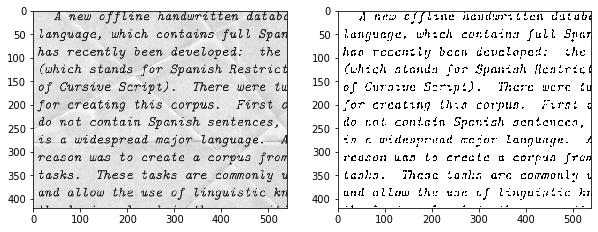

In [41]:
# Let's test our model on a sample test image
sample_test = load_img(test/ test_images[10], grayscale=True, target_size=(420,540))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

# Get the predition
predicted_label = np.squeeze(autoencoder.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')
plt.show()